In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import keras
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model,model_from_json
from keras.layers import Dense, Dropout, LSTM,BatchNormalization,TimeDistributed,Flatten,Bidirectional

In [ ]:
# reading data from csv file which has normalised data of the beta component of EEG signal

df=pd.read_csv('all.csv',header=None)
df.shape

(332433, 16)

In [ ]:
data=np.array(df)
data = data[:170000,:]
print(data.shape)
print(data)

(170000, 16)
[['L1_abhay_M_38_1.txt' 2.3714 80.95 ... -10.859 -0.1315 'M']
 ['L1_abhay_M_38_1.txt' 2.5153 83.811 ... -11.373 -0.19861 'M']
 ['L1_abhay_M_38_1.txt' 2.6574 86.567 ... -11.861 -0.2631 'M']
 ...
 ['L2_anuj1_M_13_8.txt' 2.3439 -10.487 ... 7.5518 6.7765 'M']
 ['L2_anuj1_M_13_8.txt' 2.7936 -11.012 ... 9.5795 7.1297 'M']
 ['L2_anuj1_M_13_8.txt' 3.1878 -11.464 ... 11.461 7.4182 'M']]


In [ ]:
# pick a large window size of 25 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[:,seq_cols]
    
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [ ]:
# converting input data to a 50*14 column batch with 1 label defined for each id

sequence_cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

seq_gen = (list(gen_sequence(data[data[0:,0]==id], sequence_length, sequence_cols)) 
          for id in np.unique(data[0:,0]))

seq_array = np.concatenate(list(seq_gen))
print(seq_array.shape)
seq_array

(137050, 50, 15)


array([[[242.96, 615.14, 410.71, ..., 572.63, 418.78, 'F'],
        [253.1, 638.1, 428.09, ..., 593.28, 432.79, 'F'],
        [261.8, 657.5, 443.29, ..., 610.52, 444.24, 'F'],
        ...,
        [-82.405, -208.42, -146.71, ..., -252.05, -179.68, 'F'],
        [-87.993, -218.82, -161.76, ..., -260.44, -182.45, 'F'],
        [-93.691, -229.43, -176.99, ..., -268.81, -185.19, 'F']],

       [[253.1, 638.1, 428.09, ..., 593.28, 432.79, 'F'],
        [261.8, 657.5, 443.29, ..., 610.52, 444.24, 'F'],
        [268.98, 673.14, 456.19, ..., 624.14, 452.98, 'F'],
        ...,
        [-87.993, -218.82, -161.76, ..., -260.44, -182.45, 'F'],
        [-93.691, -229.43, -176.99, ..., -268.81, -185.19, 'F'],
        [-99.406, -240.04, -192.22, ..., -276.96, -187.78, 'F']],

       [[261.8, 657.5, 443.29, ..., 610.52, 444.24, 'F'],
        [268.98, 673.14, 456.19, ..., 624.14, 452.98, 'F'],
        [274.59, 684.92, 466.71, ..., 634.07, 458.96, 'F'],
        ...,
        [-93.691, -229.43, -176.99, .

In [ ]:
# shuffling seq_array for better model prediction
from sklearn.utils import shuffle
seq_array = shuffle(seq_array)

In [ ]:
train_final=seq_array[0:110000,:,0:14]
test_final=seq_array[110000:,:,0:14]
from sklearn import preprocessing
train_label=seq_array[0:110000,0,14]
test_label=seq_array[110000:,0,14]
lb = preprocessing.LabelBinarizer()
train_label=lb.fit_transform(train_label)
test_label=lb.fit_transform(test_label)
train_label=train_label.reshape((train_label.shape[0],1))
train_label=train_label.astype('int')
test_label=test_label.astype('int')
print(train_final.shape)
print(train_label.shape)
print(test_final.shape)
print(test_label.shape)


(110000, 50, 14)
(110000, 1)
(27050, 50, 14)
(27050, 1)


In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
# building our model

nb_features = train_final.shape[2]
nb_out = train_label.shape[1]

model = Sequential()

model.add(Bidirectional(LSTM( units=512,
         return_sequences=True),
         input_shape=(sequence_length, nb_features),
        ))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(
         units=256,
         return_sequences=True))

model.add(BatchNormalization())
model.add(LSTM(
         units=128,
         return_sequences=True))

model.add(BatchNormalization())
model.add(LSTM(
          units=64,
          return_sequences=False))

model.add(BatchNormalization())
model.add(Dense(units=32))
model.add(Dense(units=nb_out, activation='sigmoid'))
tensorflow.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 50, 1024)         2158592   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 1024)          0         
                                                                 
 batch_normalization (BatchN  (None, 50, 1024)         4096      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 50, 256)           1311744   
                                                                 
 batch_normalization_1 (Batc  (None, 50, 256)          1024      
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# training the model with train dataset

train_final = np.asarray(train_final).astype(np.float32)
train_label = np.asarray(train_label).astype(np.float32)
test_final = np.asarray(test_final).astype(np.float32)
test_label = np.asarray(test_label).astype(np.float32)
model.fit(train_final,train_label,validation_split=0.2,epochs=10, batch_size=32,verbose=1)

Epoch 1/10
2750/2750 [==============================] - 319s 110ms/step - loss: 0.3062 - accuracy: 0.8698 - val_loss: 0.1411 - val_accuracy: 0.9470
Epoch 2/10
2750/2750 [==============================] - 299s 109ms/step - loss: 0.1168 - accuracy: 0.9577 - val_loss: 0.0516 - val_accuracy: 0.9823
Epoch 3/10
2750/2750 [==============================] - 301s 109ms/step - loss: 0.0675 - accuracy: 0.9764 - val_loss: 0.0398 - val_accuracy: 0.9865
Epoch 4/10
2750/2750 [==============================] - 300s 109ms/step - loss: 0.0510 - accuracy: 0.9830 - val_loss: 0.0462 - val_accuracy: 0.9853
Epoch 5/10
2750/2750 [==============================] - 299s 109ms/step - loss: 0.0444 - accuracy: 0.9854 - val_loss: 0.0251 - val_accuracy: 0.9914
Epoch 6/10
2750/2750 [==============================] - 299s 109ms/step - loss: 0.0375 - accuracy: 0.9881 - val_loss: 0.0338 - val_accuracy: 0.9890
Epoch 7/10
2750/2750 [==============================] - 299s 109ms/step - loss: 0.0337 - accuracy: 0.9892 - val_

In [ ]:
# compiling our model for the test dataset

tensorflow.keras.optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
scores = model.evaluate(test_final, test_label, verbose=1, batch_size=32)
scores[1]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


846/846 [==============================] - 40s 43ms/step - loss: 0.0167 - accuracy: 0.9947


0.9947134852409363

In [ ]:
# evaluating accuracy and confusion matrix for our model

y_pred_test = np.round_(model.predict(test_final))

y_true_test = test_label

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm_test = confusion_matrix(y_true_test, y_pred_test)
print(cm_test)

# compute precision and recall

precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[ 8542    67]
 [   76 18365]]
Precision:  0.9963650173611112 
 Recall:  0.9958787484409739 
 F1-score: 0.9961218235565319


In [ ]:
scores_test = model.evaluate(test_final,test_label, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

846/846 - 29s - loss: 0.0167 - accuracy: 0.9947 - 29s/epoch - 34ms/step
Accurracy: 0.9947134852409363


In [ ]:
# defining fuction to plot confuion matrix as a figure, shown below

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    # plt.rcParams["figure.figsize"] = (10,10)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig('confusion_matrix_gender_alpha.png',bbox_inches='tight')

Confusion matrix, without normalization
[[ 8542    67]
 [   76 18365]]


<Figure size 504x504 with 0 Axes>

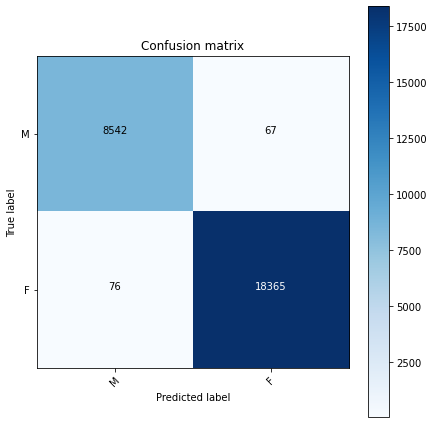

In [ ]:
# Plot non-normalized confusion matrix

class_names=['M','F']
plt.figure()
plt.rcParams["figure.figsize"] = (6,6)

plot_confusion_matrix(cm_test, classes=class_names,
                      title='Confusion matrix')
plt.show()